# Tensor_SVD vs. PCA_in_HyperSpy

### General packages

In [1]:
from tqdm.notebook import tqdm
import time

import hyperspy.api as hs
import numpy as np
import matplotlib.pyplot as plt

### Custom-written functions

In [2]:
def get_EELS_calibration_from(raw_data, ref_data):
    
    # The function of get_calibration_from
    for i in range(len(raw_data.data.shape)):
        raw_data.axes_manager[i].name=ref_data.axes_manager[i].name
        raw_data.axes_manager[i].offset=ref_data.axes_manager[i].offset
        raw_data.axes_manager[i].scale=ref_data.axes_manager[i].scale
        raw_data.axes_manager[i].units=ref_data.axes_manager[i].units
    
    return raw_data

In [3]:
def OrganizeInputSpectrum(spectrum_hs):
    spectrumraw = spectrum_hs.data
    
    disp = spectrum_hs.axes_manager[0].scale
    offset = spectrum_hs.axes_manager[0].offset
    
    EnergyAxes = np.linspace(0, spectrumraw.shape[0]-1, spectrumraw.shape[0]) * disp + offset
    return spectrumraw, disp, EnergyAxes

In [4]:
def OrganizeInputSI(SI_hs):
    SIraw = SI_hs.data
    XY = SIraw.shape[:2]
    disp = SI_hs.axes_manager[2].scale
    offset = SI_hs.axes_manager[2].offset
    
    EnergyAxes = np.linspace(0, SIraw.shape[2]-1, SIraw.shape[2]) * disp + offset
    return SIraw, XY, disp, EnergyAxes

In [5]:
# define a powerlaw for the background subtraction

def SI_FitPowerlaw(E,S,fst,fen):
    ist=np.argmin(np.abs(E-fst));ien=np.argmin(np.abs(E-fen))
    elog=np.log(E[ist:ien][np.where(S[ist:ien]>0)])
    slog=np.log(S[ist:ien][np.where(S[ist:ien]>0)])
    r,A0=np.polyfit(elog,slog,1)
    E_out=E[ist:]
    BG_out=np.exp(A0)*E[ist:]**(r)
    S_out=S[ist:]-BG_out
    
    return S_out

### Data import

In [6]:
SI = hs.load(r'D:\UCAS_data\Experimental Data_UCAS\60kV Si@Graphene CoreLoss\20221018 60kV\32mrad1i 15pA\SI-1\Non-rigid registration\crop_SI.rpl')
SI_ADF = hs.load(r'D:\UCAS_data\Experimental Data_UCAS\60kV Si@Graphene CoreLoss\20221018 60kV\32mrad1i 15pA\SI-1\Non-rigid registration\crop_ADF.rpl')

In [7]:
%%time

SIraw, XY, disp, EnergyAxes = OrganizeInputSI(SI)
r1a = 251.5
r1b = 281.5

SI_edge_data = np.array([[SI_FitPowerlaw(EnergyAxes,s,r1a,r1b) for s in row] for row in tqdm(SIraw)])
print('Data shape: '+str(SI_edge_data.shape))

  0%|          | 0/45 [00:00<?, ?it/s]

Data shape: (45, 45, 775)
Wall time: 519 ms


In [8]:
SI_edge = hs.signals.EELSSpectrum(SI_edge_data)
SI_edge.data[SI_edge.data<0]=0   # can improve the result, enhancing the mapping contrast
get_EELS_calibration_from(SI_edge, SI.isig[r1a:])

<EELSSpectrum, title: , dimensions: (45, 45|775)>

## tensor_svd_denoise
#### The tensor_svd_denoise.py file is downloaded from https://github.com/paul-voyles/tensor_svd

In [9]:
from tensor_svd_denoise import scree_plots, tensor_svd_denoise
SI_edge_data = np.copy(SI_edge.data)

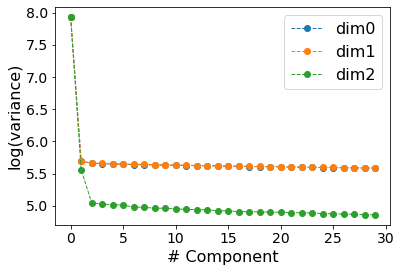

In [10]:
# Define the number of components that will be returned from scree_plots function, if ndim is not defined, ncomponents along
# each dimension will be set to the full size of that dimension
ndim = []
scree = scree_plots(SI_edge_data,ndim)

# Plot the first 30 components along each dimension in log scale

for i in range(len(scree)):
    plt.plot(np.log(scree[i][0:30]), marker='o', linestyle='dashed',linewidth=1, markersize=6, label = 'dim' + str(i))
plt.legend(fontsize=16)
plt.xlabel('# Component', fontsize=16)
plt.ylabel('log(variance)',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [11]:
# Call tensor SVD using pre-determined ranks and a timer
start = time.time()
rank = [40,40,5]
data_denoised = tensor_svd_denoise(SI_edge_data,rank)
end = time.time()
print('Time elapsed: '+ "{:.2f}".format(end-start) +' sec.')
print('SVD finished.')

Time elapsed: 1.02 sec.
SVD finished.


<AxesSubplot:xlabel='x (eV)', ylabel='Intensity'>

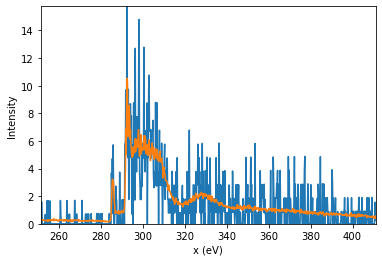

In [12]:
denoised_SI_edge = hs.signals.EELSSpectrum(data_denoised)
get_EELS_calibration_from(denoised_SI_edge, SI.isig[r1a:])

hs.plot.plot_spectra([SI_edge.inav[0,1], denoised_SI_edge.inav[0,1]], style='overlap')

## PCA via HyperSpy
#### https://hyperspy.org/hyperspy-doc/current/user_guide/mva.html#machine-learning

Time elapsed: 0.26 sec.
PCA finished.


<AxesSubplot:title={'center':'\nPCA Scree Plot'}, xlabel='Principal component index', ylabel='Proportion of variance'>

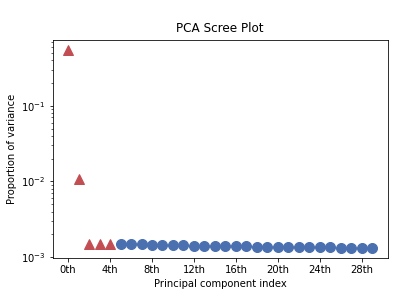

In [13]:
SI_edge.data[SI_edge.data<0]=0

start = time.time()
SI_edge.decomposition(True, print_info=False)
end = time.time()
print('Time elapsed: '+ "{:.2f}".format(end-start) +' sec.')
print('PCA finished.')

SI_edge.plot_explained_variance_ratio(threshold=5)

<AxesSubplot:xlabel='x (eV)', ylabel='Intensity'>

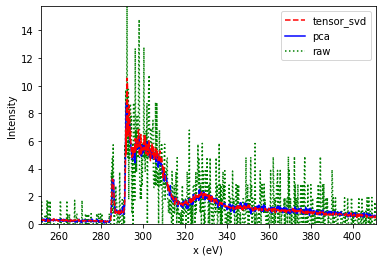

In [14]:
re_SI_edge=SI_edge.get_decomposition_model(5)
hs.plot.plot_spectra([SI_edge.inav[0,1], re_SI_edge.inav[0,1], denoised_SI_edge.inav[0,1]],
                     color=['green','blue','red'], linestyle=['dotted','solid','dashed'], 
                     style='overlap', legend=['raw','pca','tensor_svd'])

In [15]:
map_1 = SI_edge.isig[291.0:295.0].integrate1D(axis="x")
map_2 = re_SI_edge.isig[291.0:295.0].integrate1D(axis="x") 
map_3 = denoised_SI_edge.isig[291.0:295.0].integrate1D(axis="x") 


([], [])

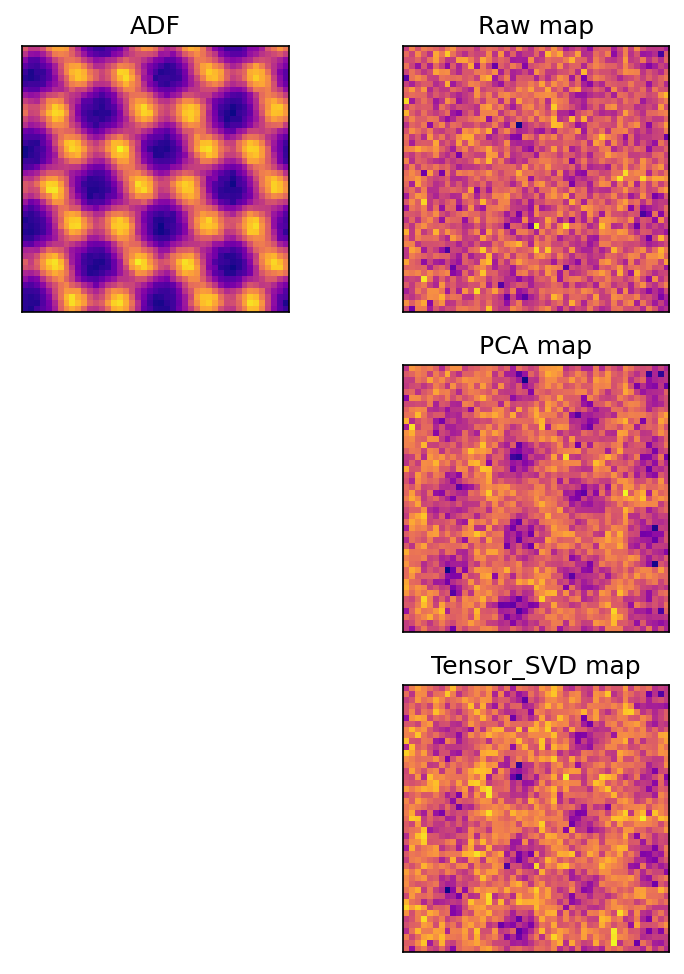

In [16]:
fig=plt.figure(figsize=(6,8),dpi=150)

ax1=fig.add_subplot(321)
ax1.imshow(SI_ADF.data,cmap='plasma')
ax1.set_title('ADF')
plt.xticks([])
plt.yticks([])
ax2=fig.add_subplot(322)
ax2.imshow(map_1.data,cmap='plasma')
ax2.set_title('Raw map')
plt.xticks([])
plt.yticks([])

ax3=fig.add_subplot(324)
ax3.imshow(map_2.data,cmap='plasma')
ax3.set_title('PCA map')
plt.xticks([])
plt.yticks([])

ax3=fig.add_subplot(326)
ax3.imshow(map_3.data,cmap='plasma')
ax3.set_title('Tensor_SVD map')
plt.xticks([])
plt.yticks([])